In [ ]:
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifWriter
from pymatgen.electronic_structure.plotter import BSPlotter
from matplotlib import pyplot as plt
import pymatgen.electronic_structure.bandstructure as bandstr
import numpy as np
with MPRester("rmVZuN7gqE6pdzRC") as m:
    structure = m.get_structure_by_material_id("mp-661")
    bandstructure = m.get_bandstructure_by_material_id("mp-661")

## 1) Détermination de la bande interdite

Caractéristiques de la bande interdite 

Bande interdite directe ?  True
Bande interdite métallique? False
Energie de la bande interdite : 4.0536 eV
Type de transition de bande interdite :  \Gamma-\Gamma
Energie de Fermi :  6.26016226


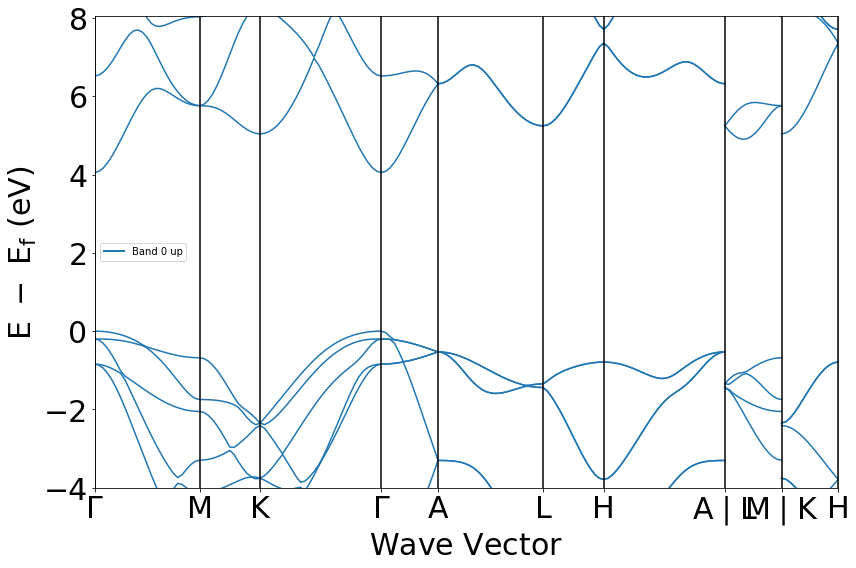

In [114]:
#bande interdite
bandGap = bandstructure.get_band_gap()

#figure de bande 
figureBand= BSPlotter(bandstructure)

#caractéristiques de la bande 
print ('Caractéristiques de la bande interdite', '\n')
print('Bande interdite directe ? ', bandGap['direct'])
print('Bande interdite métallique?', figureBand.bs_plot_data().get("is_metal"))
print('Energie de la bande interdite :', bandGap['energy'], 'eV') 
print('Type de transition de bande interdite : ', bandGap['transition'])
print('Energie de Fermi : ', bandstructure.efermi)

#Affichage de la structure de bande 
figureBand.show()

Comme observé sur la structure de bandes ci-dessous, on voit que le maximum de la dernière bande de valence (vbm) est aligné avec le minimum de la première bande de conduction (cbm). Ils se situent à valeur voisine du nombre d'onde k. Cela indique la présence d'une bande directe. Les électrons peuvent passer de la bande de valence à la bande de conduction grâce à l'échange d'un photon. Le nitrure d'aluminium est un semi-conducteur à large bande interdite.

## 2) Recherche de la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion.

La plus grande/petite dispersion pour la bande de valence ou la bande de conduction représente la plus grande/petite pente entre 2 k-points (entre 2 vecteurs d'onde représentés par les barres verticales sur la structure des bandes). On va donc chercher où se trouve la plus grande/petite pente sur chaque branche de la zone de Brillouin pour la dernière bande de valence et la première bande de conduction.  La pente représente la variation de l'énergie E-E_f par rapport à k, le vecteur d'onde. On aura une petite dispersion de la bande lorsque la variation de l'énergie est faible par rapport à k et une grande dispersion de bande lorsque la variation de l'énergie est forte par rapport à k. Pour le AlN, nous allons examiner la dispersion sur la dernière bande de valence, la 7ème bande et sur la première bande de conduction : la 8ème bande. 

In [170]:
#récupération du vbm et cbm 
vbm = bandstructure.get_vbm()
cbm = bandstructure.get_cbm() 

#récupération des énergies, distances 
data = figureBand.bs_plot_data()
energy = data["energy"]
ticks = data.get('ticks')
dist = data.get('distances')
branche = ticks.get('distance')


#branche2 : sans les doublons, il y a au total 9 branches : Г-M; M-K; K-Г ; Г-A ; A-L; L-H; H- A|L; A|L-M|K; M|K - H
branche2 = np.array([branche[0], branche[1], branche[3], branche[5], branche[7], branche[9], branche[11], branche[13], branche[14], branche[15]])

dist_branche = branche2[1:] - branche2[:-1] #longueur de chaque branche (zone de brillouin)

##Recherche de la plus grande/petite pente en valeur absolue sur chaque branche
x_init = 0
y_init = energy.get('1')[0][7][0] #énergie à gauche
x_f = 0
y_f = energy.get('1')[0][7][-1] #énergie à droite
penteMax = 0
penteMin = 500  

ordonnéesMax = [0,0]
ordonnéesMin = [0,0]
branchMax = 0
branchMin = 0
abscissesMax= [0,0]
abscissesMin=[0,0]


for x in dist: 
    for i in range(np.size(dist_branche)):
        #les y représentent les différentes ordonnées : énergies
        #Les x représentent les abscisses, valeurs de k
        x_init = x[0]#extrémité gauche de la branche 
        x_f = x[len(x)-1]#extremité droite de la branch
        y_init = energy.get('1')[i][7][0]
        y_f = energy.get('1')[i][7][-1]
        
        #pente = deltaY/deltaX
        pente = np.abs((y_f-y_init)/(x_f-x_init))
        if pente <= penteMin : 
            penteMin = pente
            ordonnéesMin = [y_init,y_f]
            branchMin = i+1
            abscissesMin=[branche2[i],branche2[i+1]]
        elif pente >= penteMax : 
            penteMax = pente 
            branchMax = i+1
            ordonnéesMax = [y_init,y_f]
            abscissesMax = [branche2[i],branche2[i+1]]


##BANDE DE VALENCE
print(' --> Dispersion max pour dernière bande de valence : se situe dans la branche K-Г ')
print('Energie pour la + grande dispersion comprise entre : ', ordonnéesMax, 'eV')

print('Valeur de la pente maximale', penteMax)
print('Sur la branche numéro', branchMax, 'avec les abscisses comprises entre :', abscissesMax ,'\n')
print('\n')

print ('--> Dispersion min pour dernière bande de valence : se situe dans la branche H - A|L') 
print('Energie pour la + petite dispersion comprise entre : ', ordonnéesMin, 'eV')
print('Valeur de la pente minimale', penteMin)
print('Sur la branche numéro ', branchMin, 'avec les abscisses comprises entre :',abscissesMin, '\n')
print('\n')


 --> Dispersion max pour dernière bande de valence : se situe dans la branche K-Г 
Energie pour la + grande dispersion comprise entre :  [-2.3482, 0.0] eV
Valeur de la pente maximale 3.7499494778670446
Sur la branche numéro 3 avec les abscisses comprises entre : [1.8289380138106341, 3.1678136225192537] 



--> Dispersion min pour dernière bande de valence : se situe dans la branche H - A|L
Energie pour la + petite dispersion comprise entre :  [-0.7896999999999998, -0.5297000000000001] eV
Valeur de la pente minimale 0.19419279753014165
Sur la branche numéro  7 avec les abscisses comprises entre : [5.622946739453159, 6.961822348161787] 





In [178]:
##BANDE DE CONDUCTION

##Recherche de la plus grande/petite pente en valeur absolue sur chaque branche
x_init = 0
y_init = energy.get('1')[0][8][0] #énergie à gauche
x_f = 0
y_f = energy.get('1')[0][8][-1] #énergie à droite
penteMax = 0
penteMin = 500  

ordonnéesMax = [0,0]
ordonnéesMin = [0,0]
branchMax = 0
branchMin = 0
abscissesMax= [0,0]
abscissesMin=[0,0]


for x in dist: 
    for i in range(np.size(dist_branche)):
        #les y représentent les différentes ordonnées : énergies
        #Les x représentent les abscisses, valeurs de k
        x_init = x[0]#extrémité gauche de la branche 
        x_f = x[len(x)-1]#extremité droite de la branch
        y_init = energy.get('1')[i][8][0]
        y_f = energy.get('1')[i][8][-1]
        
        #pente = deltaY/deltaX
        pente = np.abs((y_f-y_init)/(x_f-x_init))
        if pente <= penteMin : 
            penteMin = pente
            ordonnéesMin = [y_init,y_f]
            branchMin = i+1
            abscissesMin=[branche2[i],branche2[i+1]]
        elif pente >= penteMax : 
            penteMax = pente 
            branchMax = i+1
            ordonnéesMax = [y_init,y_f]
            abscissesMax = [branche2[i],branche2[i+1]]


##BANDE DE CONDUCTION
print(' --> Dispersion max pour première bande de conduction : se situe dans la branche M|K - H ')
print('Energie pour la + grande dispersion comprise entre : ', ordonnéesMax, 'eV')

print('Valeur de la pente maximale', penteMax)
print('Sur la branche numéro', branchMax, 'avec les abscisses comprises entre :', abscissesMax ,'\n')
print('\n')

print ('--> Dispersion min pour première bande de conduction : se situe dans la branche A|L - M|K') 
print('Energie pour la + petite dispersion comprise entre : ', ordonnéesMin, 'eV')
print('Valeur de la pente minimale', penteMin)
print('Sur la branche numéro ', branchMin, 'avec les abscisses comprises entre :',abscissesMin, '\n')
print('\n')


 --> Dispersion max pour première bande de conduction : se situe dans la branche M|K - H 
Energie pour la + grande dispersion comprise entre :  [5.0409999999999995, 7.358200000000001] eV
Valeur de la pente maximale 3.7004441402408323
Sur la branche numéro 9 avec les abscisses comprises entre : [7.588017451285056, 8.214212554408325] 



--> Dispersion min pour première bande de conduction : se situe dans la branche A|L - M|K
Energie pour la + petite dispersion comprise entre :  [5.2459999999999996, 5.7602] eV
Valeur de la pente minimale 0.3840536018846117
Sur la branche numéro  8 avec les abscisses comprises entre : [6.961822348161787, 7.588017451285056] 





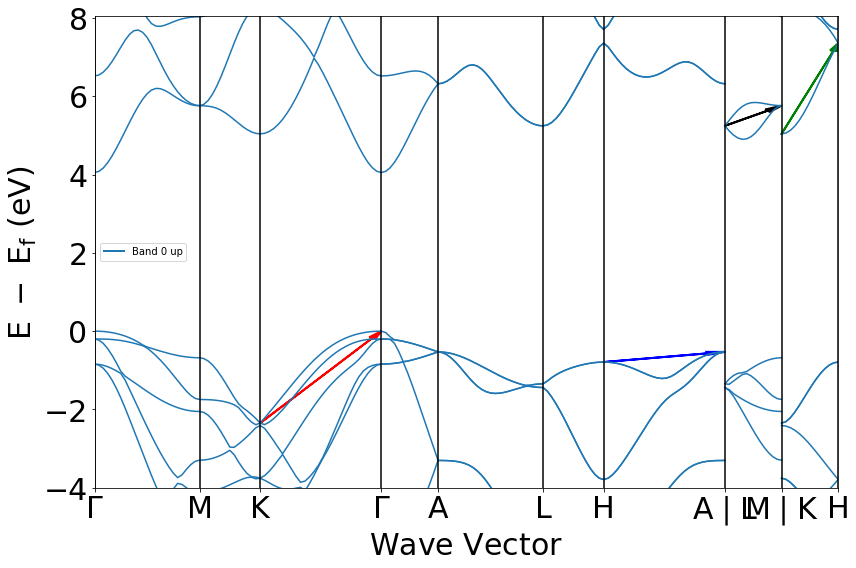

In [218]:
x_Gamma1 = branche[0]
x_M = branche[1]
x_K = branche[3]
x_Gamma2 = branche[5]
x_A = branche[7]
x_L = branche[9]
x_H1= branche[11]
x_AL = branche[13]#discontinuité à partir de là
x_MK = branche[14]
x_H2 = branche[15]

#Première flèche : dispersion max bande de valence K-Г 
dx1 = x_Gamma2 - x_K
y_Gamma2 = energy.get('1')[2][7][-1]
y_K = energy.get('1')[1][7][-1]
dy1 = y_Gamma2 - y_K

#Deuxième flèche : dispersion min bande de valence  H - A|L
dx2 = x_AL - x_H1
y_AL = energy.get('1')[6][7][-1] 
y_H1 = energy.get('1')[5][7][-1]
dy2 = y_AL - y_H1

#Troisième flèche : dispersion max bande de conduction M|K - H
dx3 = x_H2 - x_MK 
y_MK1 = energy.get('1')[8][8][0]
y_H2 = energy.get('1')[8][8][-1]
dy3 = y_H2 - y_MK1

#Quatrième flèche : dispersion min bande de conduction A|L - M|K
y_AL = energy.get('1')[7][8][0]
dx4 = x_MK - x_AL 
y_MK2 = energy.get('1')[7][8][-1]
dy4 = y_MK2 - y_AL 

figureBand.get_plot()
#1ère flèche 
plt.arrow(x_K, y_K, dx1, dy1, head_width=0.08, head_length=0.2, linewidth=2, color='red',length_includes_head=True)
#2ème flèche
plt.arrow(x_H1, y_H1, dx2, dy2, head_width=0.08, head_length=0.2, linewidth=2, color='blue',length_includes_head=True)
#3ème flèche
plt.arrow(x_MK, y_MK1, dx3, dy3, head_width=0.08, head_length=0.2, linewidth=2, color='green',length_includes_head=True)
#4ème flèche
plt.arrow(x_AL, y_AL, dx4, dy4, head_width=0.08, head_length=0.2, linewidth=2, color='black',length_includes_head=True)

## 3) Calcul de la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique

Pour calculer la masse effective $m^*$, on utilise l'équation suivante :
\begin{equation}
m^*=\frac{\hbar^2}{\frac{\partial^2 E}{\partial k^2}}
\end{equation}
En utilisant l'hypothèse de dispersion parabolique, nous pouvons approximer l'équation par : 
\begin{equation}
E(k)-E_0 = \frac{\hbar^2}{2m^*}k^2 \Rightarrow m^* = \frac{\hbar^2 k^2}{2E}
\end{equation}

In [132]:
#définition de hbar en eVs
hbar = 6.582119570 * 1e-16 

#récupération du vecteur d'onde k (1/Angström) 
#(k idem pour le vbm ou cbm vu que c'est une bande directe)
k1= np.linalg.norm(vbm['kpoint'].cart_coords)
k2 = np.linalg.norm(cbm['kpoint'].cart_coords)

print('La norme du vecteur k associé au cbm (k2) et au vbm (k1) vaut', k1 )


Evbm = vbm['energy']
Ecbm = cbm['energy']


La norme du vecteur k associé au cbm (k2) et au vbm (k1) vaut 0.0


Comme observé ci-dessus, que ce soit pour le vecteur d'onde associé au cbm ou au vbm, sa norme est nulle. Pour utiliser la formule qui donne la masse effective trouvée ci-dessus, on va utiliser le fait que le réseau soit périodique càd que $E_{n,k} = E_{n,k+G}$ où n est le numéro de bande et $g = hA + kB + lC$ est le vecteur du réseau réciproque. 
Ainsi, on peut exprimer la norme $ g = n \frac{2\pi}{a}$ où
n est un nombre entier (1,2,3...) et a est un vecteur du réseau direct. 

In [133]:
a = 3.128674875 # longueur du vecteur de base a en Angström
g = 2 * np.pi / a 

mEff_vbm = (hbar**2 * (g**2))/(2*Evbm)
mEff_cbm = (hbar**2 * (g**2))/(2*Ecbm)

print('La masse effective au sommet de la dernière bande de valence est de :', mEff_vbm, 'kg')
print('La masse effective à la base de la première bande de conduction est de : ', mEff_cbm, 'kg')




La masse effective au sommet de la dernière bande de valence est de : 1.4609874495342867e-31 kg
La masse effective à la base de la première bande de conduction est de :  8.707389095998485e-32 kg
